<a href="https://colab.research.google.com/github/nafis-neehal/ML_PROJ_RPI/blob/main/HW4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Task 1: Seq-to-Seq models with RNN and GRU for French-English Machine Translation

## Imports and Installs
We use French to English Translation dataset for this problem. There are around 3.5k translated sentence pairs from french to english language. We use Pyter3 for TER Score calculate to evaluate machine translation quality besides BLEU score implementation in torchtext. \\

Data Source: https://download.pytorch.org/tutorial/data.zip

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# ! pip install pyter3

In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
from tqdm import tqdm

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torchtext.data.metrics import bleu_score

import pyter 
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker

%matplotlib inline 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Language Class and Processing

Language Class objects hold relevant information about the two languages - English and French that we are dealing with. 
* word2index = mapping each unique word to unique index values
* index2word = mapping each unique index to unique words
* word2count = frequency of each word


In [ ]:
SOS_token = 0 #denotes starting of a sentence
EOS_token = 1 #denotes end of a sentence

"""
Language class - object contains information for each language
"""
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS
    """
    Split the sentence into words, spaced by 'whitespace'
    """
    def addNewSentencence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)
    """
    Update word, index mapping and corresponding counts
    """
    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [ ]:
"""
Transform Unicode characters to ASCII values
"""
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

"""
Convert them to Lowercase, trim, and remove common punctuation characters
"""
def processString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [ ]:
"""
Default: Input = French, Output = English
This function reads the French and English sentences in two different vars and 
then feed them into Class Lang to obtain corresponding information
"""

def readLanguages(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('./drive/MyDrive/ML Project Course/HW4/DATA/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[processString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

## Language Max Length and Prefixes
We are only opting for lines with max_length 10 words. And the lines have to start with these pre-defined prefixes. This is just to simply the problem. 

In [ ]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

#filter out and discard those pairs where at least one is greater than max_length
def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [ ]:
"""
Full Processing function
"""

def finalizeData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLanguages(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addNewSentence(pair[0])
        output_lang.addNewSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


## Load Data from Language File

In [ ]:
input_lang, output_lang, pairs = finalizeData('eng', 'fra', True)

Reading lines...
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
fra 4345
eng 2803
['il est en danger grave .', 'he s in grave danger .']


### Sample

In [ ]:
print(random.choice(pairs))

['ils sont tous la .', 'they re all here .']


## Split into Train, Validation and Test

For this, we take 80% of the total data pairs into training and leave the 20% for test. We then further take 90% of the training data into final training set and take the rest 10% into evaluation set.

In [ ]:
def slice_list(total):

  random.shuffle(total)

  train_shape = int(len(total)*0.80)
  test_shape = len(total) - train_shape 
  
  train_shape, validation_shape = int(train_shape*0.90), int(train_shape - train_shape*0.90)

  train, validation, test = total[:train_shape], total[train_shape:train_shape+validation_shape], total[train_shape+validation_shape:]

  return train, validation, test

train_pairs, validation_pairs, test_pairs = slice_list(pairs)

## Indexing Functions and Helpers

In [ ]:
"""
Given a sentence and corresponding language, this function returns a list of
indexes in vocab for those word in the sentence.
"""
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

"""
Returns a tensor of indexes of a sentences along with <EOS> tag added at the 
end of the sentence.
"""
def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

"""
Converts two sentences into their corresponding tensors and return those two
tensors.
"""
def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [ ]:
"""
Helper functions:
convertToMinutes: converts seconds -> minutes + seconds (remaining)
timeFrom: Calculates remaining time
"""
import time
import math

def convertToMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeFrom(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (convertToMinutes(s), convertToMinutes(rs))

## Encoder and Decoder Class

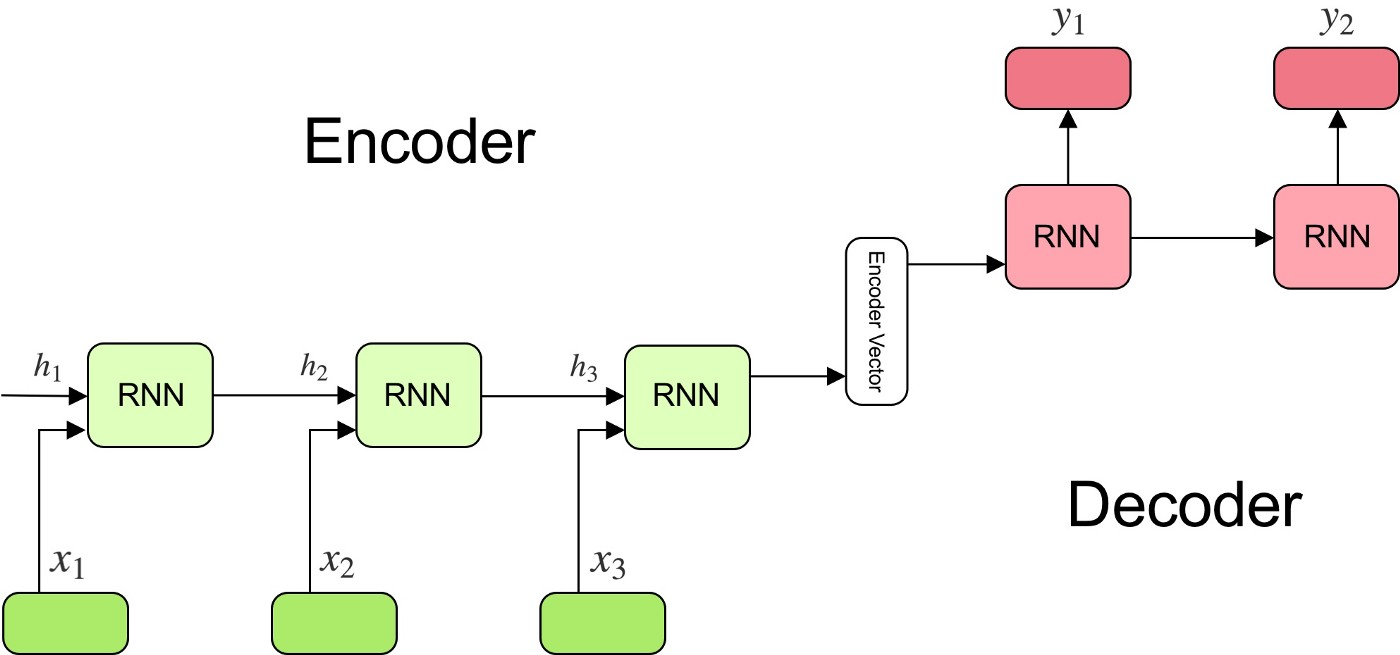

In [ ]:
from IPython.display import Image
Image(filename='./drive/MyDrive/ML Project Course/HW4/seq.jpeg') 

In [ ]:
class EncoderRNNClass(nn.Module):
    def __init__(self, input_size, hidden_size, rnn_architecture):
        super(EncoderRNNClass, self).__init__()
        self.hidden_size = hidden_size

        self.embedding_layer = nn.Embedding(input_size, hidden_size)
        self.rnn_layer = rnn_architecture(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding_layer(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.rnn_layer(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [ ]:
class DecoderRNNClass(nn.Module):
    def __init__(self, hidden_size, output_size, rnn_architecture):
        super(DecoderRNNClass, self).__init__()
        self.hidden_size = hidden_size

        self.embedding_layer = nn.Embedding(output_size, hidden_size)
        self.rnn_layer = rnn_architecture(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding_layer(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.rnn_layer(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

## Train and Train Iterations

In [ ]:
# one Train Loop
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    
    #init hidden with zeros
    encoder_hidden = encoder.initHidden()

    #clear gradients
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    #lenghts of input and target
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    #encoded output holder
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    #init loss
    loss = 0

    #save encoded outputs for each input tensor/words
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    #decode input init
    decoder_input = torch.tensor([[SOS_token]], device=device)

    #decoder hidden 1st = last hidden state of encoder
    decoder_hidden = encoder_hidden

    #Teacher forcing technique (Read in Pytorch tutorials): 
    #Feed the target as the next input
    for di in range(target_length):
        decoder_output, decoder_hidden = decoder(
            decoder_input, decoder_hidden)
        loss += criterion(decoder_output, target_tensor[di])
        decoder_input = target_tensor[di]  # Teacher forcing

    #calculate gradients
    loss.backward()

    #update encoder and decoder params
    encoder_optimizer.step()
    decoder_optimizer.step()

    #return loss
    return loss.item() / target_length

In [ ]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    #SGD optimizer
    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)

    #data - training pairs - convert each sentence pair to corresponding tensors
    training_pairs = [tensorsFromPair(random.choice(train_pairs))
                      for i in range(n_iters)]
    
    #negative log likelihood loss
    criterion = nn.NLLLoss()  #https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html

    #each epoch
    for iter in tqdm(range(1, n_iters + 1)):

        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        #save loss history for printing
        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('Loss: %.4f' % print_loss_avg)

        #save loss history for
        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    return plot_losses 

In [ ]:
#plots epoch VS loss curve
def showPlot(points, title):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    ax.set_xlabel("Epochs")
    ax.set_ylabel("NLL Loss")
    ax.set_title(title)
    plt.plot(points, color='red')
    plt.show()

## Evaluation Functions

In [ ]:
"""
Generate predicted output translations
"""
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []

        for di in range(max_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)

            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words

In [ ]:
"""
Randomly select one sentence pair and visualize and compare the translated
output and target output. Gives a literary notion about how really good the 
translation is doing.
"""
def randomVisualPresentation(encoder, decoder, eval_pairs, n=10):
    for i in range(n):
        pair = random.choice(eval_pairs)
        print('Source:', pair[0])
        print('Target:', pair[1])
        output_words = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('Predicted:', output_sentence)
        print('')

In [ ]:
"""
Evaluate BLEU score for translation - selected random samples
BLEU Score Range by Google: https://cloud.google.com/translate/automl/docs/evaluate
<.10    = almost useless
.10-.19 = Hard to get the gist
.20-.29 = The gist is clear, but has significant grammatical errors
.30-.39 = Understandable to good translations
.40-.50 = High Quality Translations
.50-.60 = Very high quality, adequate, and fluent translations
>0.60   = Quality often better than human 
"""
def evaluateBLEU(encoder, decoder, eval_pairs, n=10, max_n=4, print_on=True):
    reference_corpus = []
    candidate_corpus = []
    for i in range(n):
        pair = random.choice(eval_pairs)
        reference_corpus.append(pair[1].split(' '))
        output_words = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words).replace('<EOS>','')
        candidate_corpus.append(output_sentence.split(' '))
        #prints
        if print_on:
          print('Source:', pair[0].split(' '))
          print('Target:', pair[1].split(' '))
          print('Predicted:', output_sentence.split(' '))
          print('')
    bleu_score_calc = bleu_score(candidate_corpus, reference_corpus, max_n=max_n, weights=np.repeat(1/max_n, max_n).tolist())
    print(f"Bleu Score for Corpus Size {len(reference_corpus)} is {bleu_score_calc:0.5f}")

In [ ]:
"""
Translation Error Rate (TER) is a character-based automatic metric for measuring 
the number of edit operations needed to transform the machine-translated output 
into a human translated reference. It has been proposed as an alternative to the 
BLEU score for evaluating the quality of MT, but it is more commonly applied as 
a way of calculating edit-distance, used to assess the post-editing effort.
"""
def evaluateTER(encoder, decoder, eval_pairs, n=10, print_on=True):

    sum_of_TER = 0

    for i in range(n):
        pair = random.choice(eval_pairs)
        reference = pair[1].split(' ')

        output_words = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words).replace('<EOS>','')
        candidate = output_sentence.split(' ')
        
        #prints
        if print_on:
          print('Source:', pair[0].split(' '))
          print('Target:', reference)
          print('Predicted:', candidate)
          print('')

        sum_of_TER += pyter.ter(candidate, reference)
    
    print(f"Mean TER Score is {sum_of_TER/n:0.5f}")

## Task 1a: Performance Visualization of RNN

In [ ]:
hidden_size = 256
encoder1 = EncoderRNNClass(input_lang.n_words, hidden_size,nn.RNN).to(device)
decoder1 = DecoderRNNClass(hidden_size, output_lang.n_words,nn.RNN).to(device)

losses = runTraining(encoder1, decoder1, 20000, print_every=1000)

  5%|▌         | 1001/20000 [01:03<21:09, 14.97it/s]

Loss: 3.4757


 10%|█         | 2003/20000 [02:13<21:37, 13.87it/s]

Loss: 3.1798


 15%|█▌        | 3001/20000 [03:15<18:26, 15.37it/s]

Loss: 2.9796


 20%|██        | 4002/20000 [04:18<14:42, 18.13it/s]

Loss: 2.8874


 25%|██▌       | 5002/20000 [05:16<15:05, 16.56it/s]

Loss: 2.8177


 30%|███       | 6003/20000 [06:14<12:35, 18.53it/s]

Loss: 2.7522


 35%|███▌      | 7003/20000 [07:11<12:23, 17.47it/s]

Loss: 2.7211


 40%|████      | 8004/20000 [08:07<09:58, 20.04it/s]

Loss: 2.7153


 45%|████▌     | 9003/20000 [09:00<09:11, 19.94it/s]

Loss: 2.8399


 50%|█████     | 10002/20000 [09:48<08:32, 19.51it/s]

Loss: 2.7676


 55%|█████▌    | 11003/20000 [10:38<07:13, 20.77it/s]

Loss: 2.6978


 60%|██████    | 12003/20000 [11:26<06:19, 21.09it/s]

Loss: 2.6679


 65%|██████▌   | 13004/20000 [12:13<05:06, 22.86it/s]

Loss: 2.6653


 70%|███████   | 14003/20000 [13:02<04:45, 20.97it/s]

Loss: 2.6060


 75%|███████▌  | 15003/20000 [13:51<04:10, 19.95it/s]

Loss: 2.7523


 80%|████████  | 16002/20000 [14:41<04:23, 15.20it/s]

Loss: 2.6511


 85%|████████▌ | 17005/20000 [15:33<02:12, 22.68it/s]

Loss: 2.6348


 90%|█████████ | 18003/20000 [16:22<01:36, 20.61it/s]

Loss: 2.5399


 95%|█████████▌| 19004/20000 [17:11<00:42, 23.28it/s]

Loss: 2.5856


100%|██████████| 20000/20000 [17:59<00:00, 18.53it/s]

Loss: 2.5612


<Figure size 432x288 with 0 Axes>

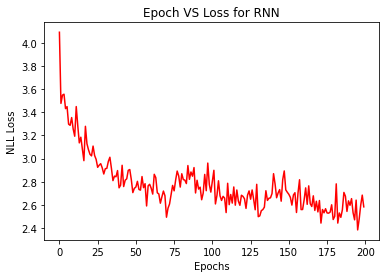

In [ ]:
showPlot(losses, "Epoch VS Loss for RNN")

In [ ]:
randomVisualPresentation(encoder1, decoder1, test_pairs)

Source: je suis en retard sur le programme .
Target: i m behind schedule .
Predicted: i m not you to leave your father . <EOS>

Source: il n a jamais ete amoureux auparavant .
Target: he s never been in love before .
Predicted: he is eager to go there . <EOS>

Source: je suis le capitaine .
Target: i m the captain .
Predicted: i m going to . that . <EOS>

Source: je ne suis pas ton fils .
Target: i m not your son .
Predicted: i m not you to leave your father . <EOS>

Source: tu es toujours vivante .
Target: you re still alive .
Predicted: you re very . <EOS>

Source: il se plaint toujours de la nourriture .
Target: he s always complaining about the food .
Predicted: he is eager to go there . <EOS>

Source: je ne vais pas porter ca .
Target: i m not wearing this .
Predicted: i m not you to leave your father . <EOS>

Source: j ai le meme age .
Target: i am the same age .
Predicted: i m going to . that . <EOS>

Source: tu vas bien .
Target: you re all right .
Predicted: you re a good pers

## Evaluate on Validation Set

In [ ]:
evaluateBLEU(encoder1, decoder1, validation_pairs, n=100, max_n=1, print_on=False)
evaluateTER(encoder1, decoder1, validation_pairs, n=100, print_on=False)

Bleu Score for Corpus Size 100 is 0.23537
Mean TER Score is 0.88053


## Evaluate on Test Set

In [ ]:
evaluateBLEU(encoder1, decoder1, test_pairs, n=100, max_n=1, print_on=False)
evaluateTER(encoder1, decoder1, test_pairs, n=100, print_on=False)

Bleu Score for Corpus Size 100 is 0.22327
Mean TER Score is 0.83560


## Task 1b: Performance Visualization of GRU


In [ ]:
hidden_size = 256
encoder2 = EncoderRNNClass(input_lang.n_words, hidden_size,nn.GRU).to(device)
decoder2 = DecoderRNNClass(hidden_size, output_lang.n_words,nn.GRU).to(device)

losses2 = runTraining(encoder2, decoder2, 20000, print_every=1000)

  5%|▌         | 1003/20000 [01:13<20:12, 15.66it/s]

Loss: 3.4507


 10%|█         | 2001/20000 [02:26<19:29, 15.40it/s]

Loss: 3.0082


 15%|█▌        | 3001/20000 [03:41<23:43, 11.95it/s]

Loss: 2.8602


 20%|██        | 4001/20000 [04:57<22:20, 11.93it/s]

Loss: 2.7210


 25%|██▌       | 5001/20000 [06:12<17:15, 14.49it/s]

Loss: 2.5428


 30%|███       | 6001/20000 [07:27<17:41, 13.19it/s]

Loss: 2.4579


 35%|███▌      | 7001/20000 [08:40<16:38, 13.02it/s]

Loss: 2.3953


 40%|████      | 8003/20000 [09:53<12:17, 16.26it/s]

Loss: 2.3209


 45%|████▌     | 9001/20000 [11:06<14:10, 12.93it/s]

Loss: 2.2600


 50%|█████     | 10001/20000 [12:24<13:41, 12.17it/s]

Loss: 2.1441


 55%|█████▌    | 11001/20000 [13:43<11:05, 13.52it/s]

Loss: 2.0839


 60%|██████    | 12001/20000 [15:06<11:10, 11.92it/s]

Loss: 2.0750


 65%|██████▌   | 13001/20000 [16:28<10:09, 11.48it/s]

Loss: 1.9805


 70%|███████   | 14001/20000 [18:01<08:04, 12.37it/s]

Loss: 1.9175


 75%|███████▌  | 15001/20000 [19:35<08:07, 10.26it/s]

Loss: 1.8703


 80%|████████  | 16001/20000 [21:07<05:43, 11.64it/s]

Loss: 1.7886


 85%|████████▌ | 17001/20000 [22:38<04:04, 12.26it/s]

Loss: 1.7604


 90%|█████████ | 18003/20000 [23:58<02:20, 14.25it/s]

Loss: 1.6503


 95%|█████████▌| 19001/20000 [25:15<01:15, 13.31it/s]

Loss: 1.7086


100%|██████████| 20000/20000 [26:35<00:00, 12.53it/s]

Loss: 1.5973


<Figure size 432x288 with 0 Axes>

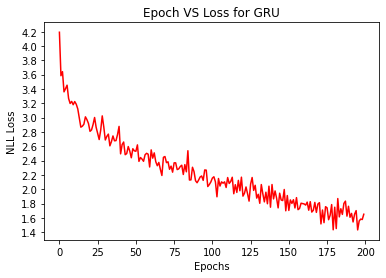

In [ ]:
showPlot(losses2, "Epoch VS Loss for GRU")

In [ ]:
randomVisualPresentation(encoder2, decoder2, test_pairs)

Source: il va avoir un choc .
Target: he s in for a shock .
Predicted: he s going to a a . . <EOS>

Source: elles ne viennent pas .
Target: they re not coming .
Predicted: they re not dead . <EOS>

Source: je suis interesse par l anglais .
Target: i am interested in english .
Predicted: i am in in of . <EOS>

Source: nous allons manquer de faire ceci .
Target: we re going to miss doing this .
Predicted: we are going to have in that . <EOS>

Source: j essaye quelque chose de nouveau .
Target: i m trying something new .
Predicted: i m from of . . <EOS>

Source: c est un homme de parole .
Target: he s a man of his word .
Predicted: he is a man of of . <EOS>

Source: tu as toujours quelque chose a me reprocher .
Target: you are always finding fault with me .
Predicted: you re going to go . <EOS>

Source: je n en suis pas sur .
Target: i m not sure about it .
Predicted: i m not sure . <EOS>

Source: c est un vieil ami a moi .
Target: he is an old friend of mine .
Predicted: he s an to me a 

## Evaluate on Validation Set

In [ ]:
evaluateBLEU(encoder2, decoder2, validation_pairs, n=100, max_n=1, print_on=False)
evaluateTER(encoder2, decoder2, validation_pairs, n=100, print_on=False)

Bleu Score for Corpus Size 100 is 0.30303
Mean TER Score is 0.60027


## Evaluate on Test Set

In [ ]:
evaluateBLEU(encoder2, decoder2, test_pairs, n=100, max_n=1, print_on=False)
evaluateTER(encoder2, decoder2, test_pairs, n=100, print_on=False)

Bleu Score for Corpus Size 100 is 0.30229
Mean TER Score is 0.60369


## Discussion
If we look at the results:
1. RNN
  * Validation
    * Bleu(maximize): 0.23
    * TER (minimize): 0.88
  * Test
    * Bleu(maximize): 0.22
    * TER (minimize): 0.83
2. GRU
  * Validation
    * Bleu(maximize): 0.30
    * TER (minimize): 0.60
  * Test
    * Bleu(maximize): 0.30
    * TER (minimize): 0.61

We can see that there is a significant performance improvement after using GRUs instead of vanilla RNN cells. This performance difference becomes specially prominent when the sentence length becomes longer (experimented with tweaking the MAX_LENGTH parameter of language). GRUs perform better because they have the ability to keep memory/state from previous activations rather than replacing the entire activation like a vanilla RNN. Also, reason behind choosing GRU over LSTM was because GRUs perform better than LSTMs when we have lower number of training samples.

Besides quality of translation, if we simply observe the loss reduction, there also GRUs outperform plain RNN.

Source: https://medium.com/paper-club/grus-vs-lstms-e9d8e2484848

# Task 2: Glove Embedding using Torchtext for pairwise similarity and dissimilarity
GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space.
Source: https://nlp.stanford.edu/projects/glove/

In [ ]:
import torch
import torchtext

In [ ]:
glove = torchtext.vocab.GloVe(name='6B', dim=100)

.vector_cache/glove.6B.zip: 862MB [02:40, 5.38MB/s]                           
100%|█████████▉| 399999/400000 [00:18<00:00, 21182.85it/s]


## Similarity and Dissimilarity Metric

For similarity we used Cosine similarity implemented in Pytorch. For dissimilarity, we used Frobenius norm.
Frobenius norm on the embedding space defines how far away are the two projected word-vectors are - which correlates with the notion of dissimilarity.

In [ ]:
def compare_words():
  w1 = input("Enter First Word: ")
  w2 = input("Enter Second Word: ")
  gw1 = glove[w1]
  gw2 = glove[w2]
  print(f"Cosine Similarity: {torch.cosine_similarity(gw1.unsqueeze(0), gw2.unsqueeze(0)).numpy()[0]:0.5f}")
  print(f"Eucildean Distance: {torch.norm(gw1-gw2).numpy():0.5f}")

## RUN

In [ ]:
try:
    while True:
        compare_words()

except KeyboardInterrupt:
    print("Press Ctrl-C to terminate while statement")
    pass

Enter First Word: cat
Enter Second Word: dog
Cosine Similarity: 0.87981
Eucildean Distance: 2.68113
Press Ctrl-C to terminate while statement


# References



Sources and Tutorials:
1. https://towardsdatascience.com/17-types-of-similarity-and-dissimilarity-measures-used-in-data-science-3eb914d2681
2. https://pytorch.org/text/stable/index.html
3. https://pytorch.org/text/stable/data_metrics.html
4. https://pytorch.org/text/stable/vocab.html (GloVE pre-trained word embedding)
5. https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html 
6. https://towardsdatascience.com/language-translation-with-rnns-d84d43b40571
7. http://www.adeveloperdiary.com/data-science/deep-learning/nlp/machine-translation-recurrent-neural-network-pytorch/
8. https://pytorch.org/tutorials/beginner/torchtext_translation_tutorial.html
9. https://www.analyticsvidhya.com/blog/2020/03/pretrained-word-embeddings-nlp/
10. https://towardsdatascience.com/a-comprehensive-guide-to-neural-machine-translation-using-seq2sequence-modelling-using-pytorch-41c9b84ba350 
11. https://www.nltk.org/_modules/nltk/translate/bleu_score.html